In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from algorithms import ga, de
from utils import repeat

from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.callback import Callback
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination import get_termination

In [3]:
def rosen(X):
  return np.sum((1 - X[:-1]) ** 2 + 100 * (X[1:] - X[:-1] ** 2) ** 2)

rosen_boundaries = lambda x: [(-2.048, 2.048)] * x

In [4]:
fmap = {"rand": de.mutation.rand,
       "best": de.mutation.best,
       "curr_to_best": de.mutation.curr_to_best}

X = ["best", "rand", "curr_to_best"]
Y = [1, 2]

N = 30
F = 0.8
Cr = 0.8
NP = 100


experiments = {}
for x in X:
  experiments[x] = {}
  for y in Y:
    results = repeat(30, de.minimize, rosen, rosen_boundaries(2), NP, F, Cr, x=fmap[x], y=y)
    experiments[x][y] = np.array([list(result) for result in results], dtype=[('best_x', float, (2,)), ('fitness', float)])

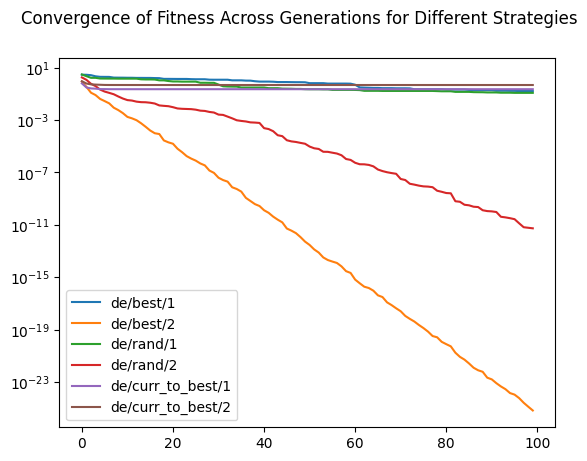

In [5]:
for x in X:
  for y in Y:
    plt.plot(np.mean(experiments[x][y]["fitness"], axis=0), label=f"de/{x}/{y}")

plt.suptitle("Convergence of Fitness Across Generations for Different Strategies")

plt.legend()
plt.yscale("log")
plt.show()

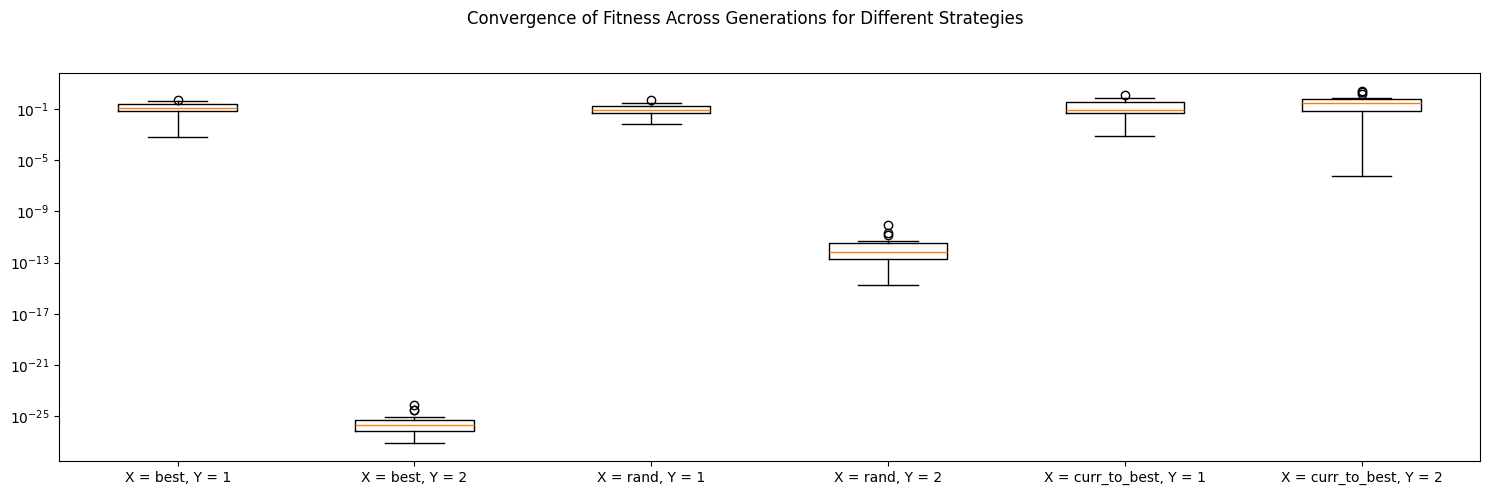

In [6]:
fig = plt.figure(figsize=(15, 5))

data = [experiments[x][y]["fitness"][:, 99] for x in X for y in Y]
plt.boxplot(data, labels=[f"X = {x}, Y = {y}" for x in X for y in Y])
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

## PyMoo Comparison

In [7]:
class SavePopulationCallback(Callback):
    def __init__(self):
        super().__init__()
        self.data = []

    def notify(self, algorithm):
        # append the deep copy of current population to data list
        best_idx = np.argmin(algorithm.pop.get("F"))
        best_x = np.float32(algorithm.pop.get("X")[best_idx])
        best_f = np.float32(algorithm.pop.get("F")[best_idx])
        self.data.append((best_x, best_f))



problem = get_problem("rosenbrock", n_var=2)

pymoo_de = lambda x, y: DE(
    pop_size=100,
    sampling=LHS(),
    variant=f"DE/{x}/{y}/bin",
    CR=0.8,
    dither="vector",
    jitter=False
)

termination = get_termination("n_gen", 100)
pymoo_experiments = {}

for x in X[:-1]:
  pymoo_experiments[x] = {}
  for y in Y:
    print(f"Running pymoo experiment for {x} and {y}")
    exp = []
    for i in range(30):
      callback = SavePopulationCallback()
      res = minimize(problem,
                   pymoo_de(x, y),
                   termination=termination,
                   seed=np.random.randint(0, 10000),
                   callback=callback)
      exp.append(callback.data)
      
    pymoo_experiments[x][y] = np.array(exp, dtype=[('best_x', float, (2,)), ('fitness', float)])

Running pymoo experiment for best and 1


/var/folders/qk/qhpk8_352d1gw4g1s3r0mlrm0000gn/T/ipykernel_90579/1272322958.py:43: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pymoo_experiments[x][y] = np.array(exp, dtype=[('best_x', float, (2,)), ('fitness', float)])


Running pymoo experiment for best and 2
Running pymoo experiment for rand and 1
Running pymoo experiment for rand and 2


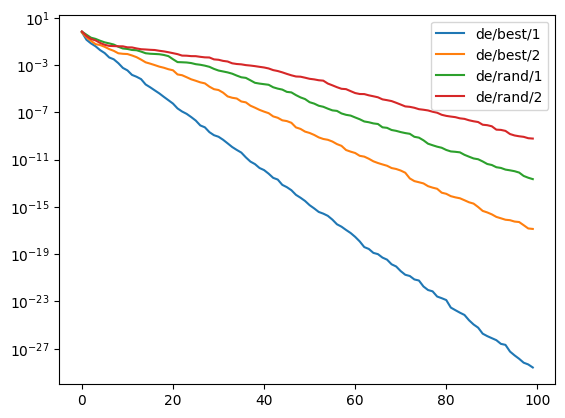

In [8]:
for x in X[:-1]:
  for y in Y:
    plt.plot(np.mean(pymoo_experiments[x][y]["fitness"], axis=0), label=f"de/{x}/{y}")

plt.legend()
plt.yscale("log")
plt.show()

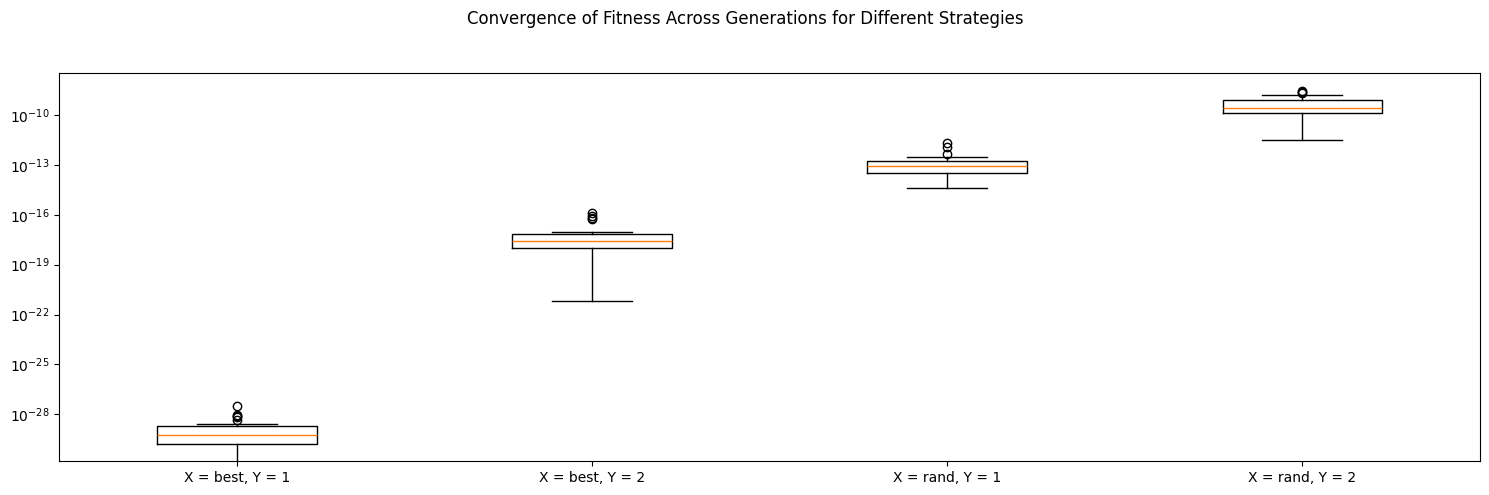

In [9]:
fig = plt.figure(figsize=(15, 5))

data = [pymoo_experiments[x][y]["fitness"][:, 99] for x in X[:-1] for y in Y]
plt.boxplot(data, labels=[f"X = {x}, Y = {y}" for x in X[:-1] for y in Y])
plt.yscale('log')

fig.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the main title
plt.show()

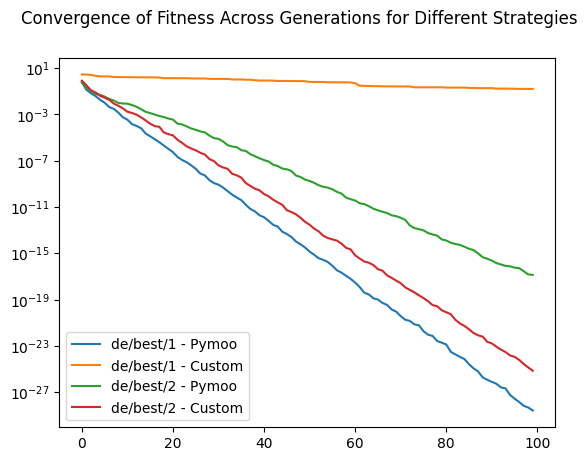

In [10]:
for y in Y:
    plt.plot(np.mean(pymoo_experiments["best"][y]["fitness"], axis=0), label=f"de/best/{y} - Pymoo")
    plt.plot(np.mean(experiments["best"][y]["fitness"], axis=0), label=f"de/best/{y} - Custom")

plt.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.legend()
plt.yscale("log")
plt.show()

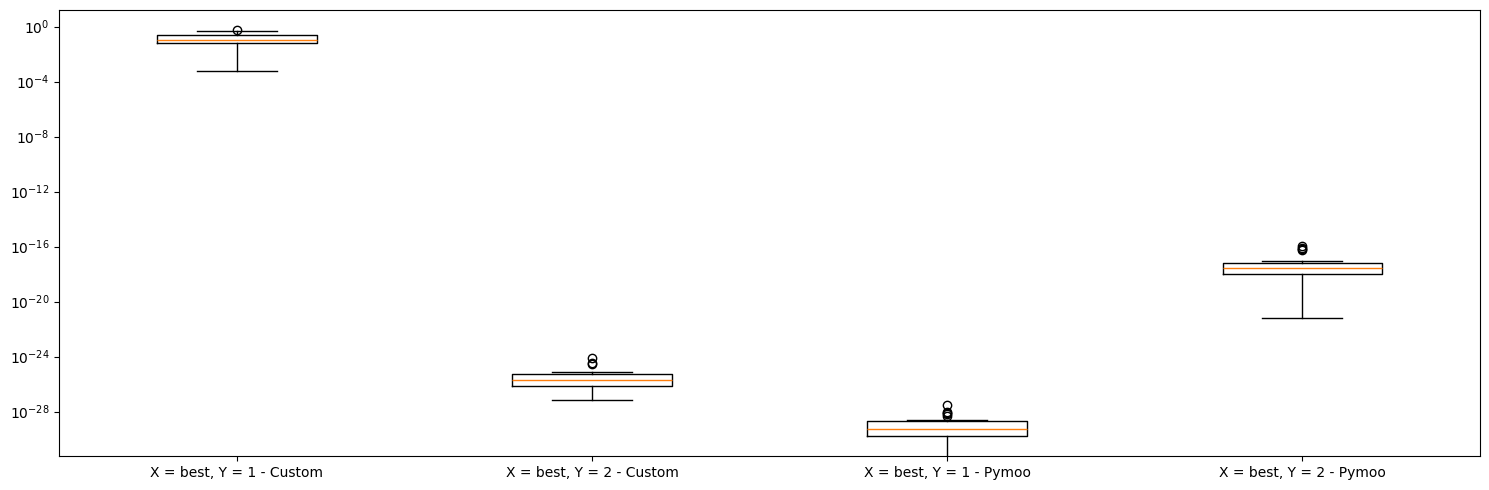

In [11]:
fig = plt.figure(figsize=(15, 5))

data = [experiments["best"][y]["fitness"][:, 99] for y in Y] + [pymoo_experiments["best"][y]["fitness"][:, 99] for y in Y]
plt.boxplot(data, labels=[f"X = best, Y = {y} - Custom" for y in Y] + [f"X = best, Y = {y} - Pymoo" for y in Y])
plt.yscale('log')

plt.tight_layout()  # Adjust layout to fit the main title
plt.show()

## Comparando com AG

In [50]:
Cr = 0.8
F = 0.05
NP = 100
repetitions = 30

results = repeat(repetitions, ga.minimize, rosen, rosen_boundaries(2), NP, F, Cr)
ga_experiments = np.array([list(result) for result in results], dtype=[('best_x', float, (2,)), ('fitness', float)])

In [58]:
from pymoo.algorithms.soo.nonconvex.ga import GA

pymoo_ga = GA(
    pop_size=100,
    eliminate_duplicates=True,
    max_gen=100)

termination = get_termination("n_gen", 100)
ga_pymoo_experiments = []

for i in range(30):
  callback = SavePopulationCallback()
  res = minimize(problem,
                pymoo_ga,
                termination=termination,
                seed=np.random.randint(0, 10000),
                callback=callback)
  ga_pymoo_experiments.append(callback.data)


ga_pymoo_experiments = np.array(ga_pymoo_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])
      


/var/folders/qk/qhpk8_352d1gw4g1s3r0mlrm0000gn/T/ipykernel_78103/3676195606.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ga_pymoo_experiments = np.array(ga_pymoo_experiments, dtype=[('best_x', float, (2,)), ('fitness', float)])


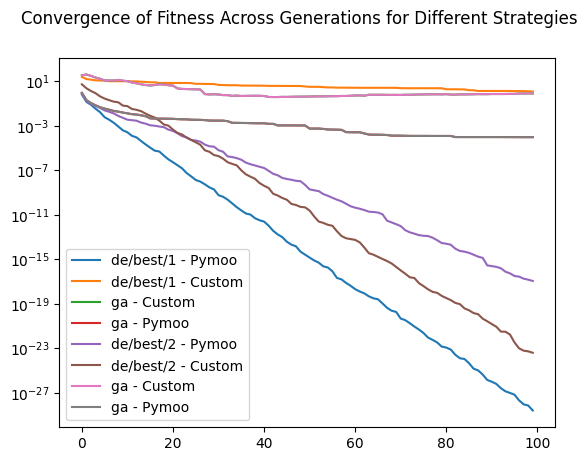

In [59]:
for y in Y:
    plt.plot(np.mean(pymoo_experiments["best"][y]["fitness"], axis=0), label=f"de/best/{y} - Pymoo")
    plt.plot(np.mean(experiments["best"][y]["fitness"], axis=0), label=f"de/best/{y} - Custom")
    plt.plot(np.mean(ga_experiments["fitness"], axis=0), label=f"ga - Custom")
    plt.plot(np.mean(ga_pymoo_experiments["fitness"], axis=0), label=f"ga - Pymoo")

plt.suptitle("Convergence of Fitness Across Generations for Different Strategies")
plt.legend()
plt.yscale("log")
plt.show()

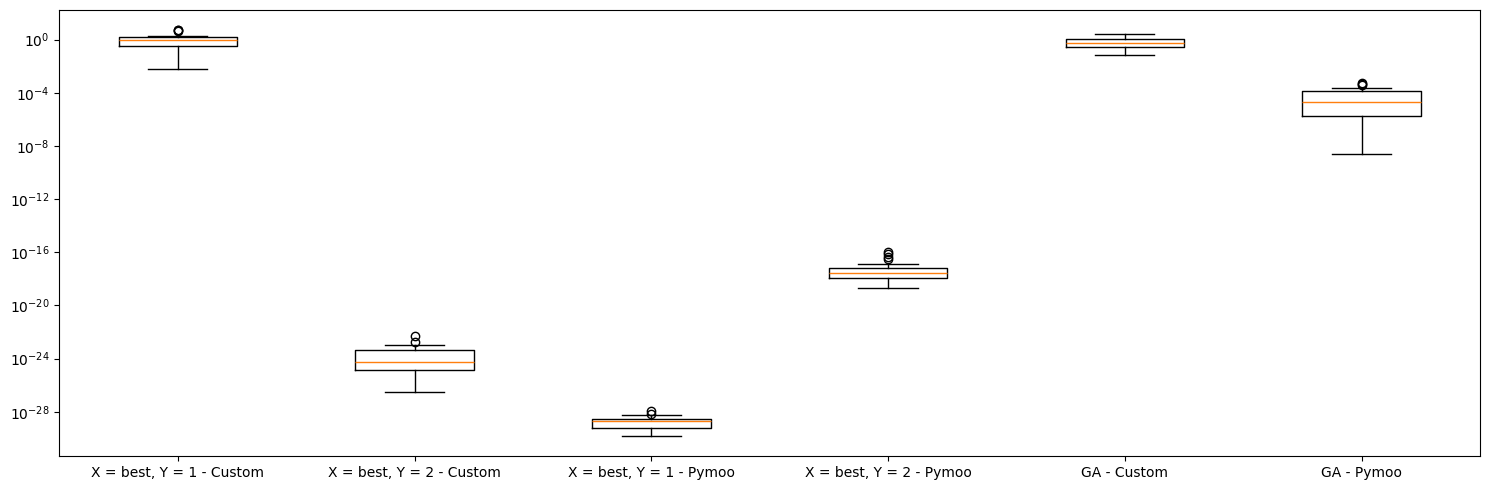

In [61]:
fig = plt.figure(figsize=(15, 5))

data = [experiments["best"][y]["fitness"][:, 99] for y in Y] + \
    [pymoo_experiments["best"][y]["fitness"][:, 99] for y in Y] + \
    [ga_experiments["fitness"][:, 99]] + \
    [ga_pymoo_experiments["fitness"][:, 99]]

labels = [f"X = best, Y = {y} - Custom" for y in Y] + \
    [f"X = best, Y = {y} - Pymoo" for y in Y] + \
    ["GA - Custom"] + \
    ["GA - Pymoo"]

plt.boxplot(data, labels=labels)
plt.yscale('log')

plt.tight_layout()  # Adjust layout to fit the main title
plt.show()